<img style="margin-left:0px;" src="http://www.radixeng.com.br/images/logos/radix-logo-completo.png">
<br>

# Criação do script.

<h4> Notebook destinado a criação do script de execução do experimento para o paper flairs-2020</h4>

## Import do Python

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Markdown, Latex,HTML
from urllib.request import urlopen

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from dateutil.parser import parse

#Internal -- imports
from src.models import load_crm,split_users_bot_human,sms_clusterization
from src.visualization import *
from src.visualization.html_visualization import *
from src.data.nota_servico_dataset import *
from src.data.servico_dataset import *

import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA,SparsePCA
from sklearn.cluster import KMeans,MiniBatchKMeans,AffinityPropagation,DBSCAN
from sklearn import metrics

from minisom import MiniSom    


stop = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

html = open("../custom_files/style.css", "r")
display(HTML("<style>\n" + "".join(html.readlines()) + "</style>"))
display(HTML("<style src='https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css'></style>"))
display(HTML("<script src='https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/js/bootstrap.min.js'></script>"))
display(HTML("<style src='https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css'></style>"))

## Funções

In [2]:
class StemmedCountVectorizer(CountVectorizer):
    def __init__(self, stemmer,binary=True,min_df=20,ngram_range=(3,3),stop_words=None,max_df=1.0):
        super(StemmedCountVectorizer, self).__init__(binary=binary,min_df = min_df,ngram_range = ngram_range, max_df=max_df,stop_words=stop_words)
        self.stemmer = stemmer
        #self.binary = binary
        #self.min_df = min_df
        #self.ngram_range = ngram_range

    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc:(self.stemmer.stem(w) for w in analyzer(doc))
    
def concatenate_list_data(list):
    result= ''    

    for element in list.values:
        result += " "+ str(element[0])
    return result

from time import time
import collections
from math import log

def bm25_indexfunction_instance_atrib(X):
    t0 = time()
    ii = collections.defaultdict(list)    
    k1 = 1.2
    k2 = 0.5   
    b  = 0.75
    
    idfs = bm25_idf_create(X,k1,k2,b)
    for d_index, t_index in np.transpose(np.nonzero(X)):
        ii[t_index].append(d_index)        
    t0 = time() - t0 
        
    return [ii,idfs,k1,k2,b], t0

def bm25_scorefunction_instance_atrib(collection_size, X):
    scores = np.zeros((X.shape[0], collection_size))
    t0 = time()    
    
    ii,idfs,k1,k2,b = bm25_indexfunction_instance_atrib(X)[0]
    X_nonzero = np.nonzero(X)   
    weight_matrix = bm25_matrix_create(X,idfs,k1,k2,b)
    weight_matrix_idfs = np.multiply(weight_matrix,idfs[X_nonzero[1]])    
    x_nonzero_transpose = np.transpose(X_nonzero)
    for i in range(X_nonzero[0].size):
        q_index, t_index = x_nonzero_transpose[i,:]
        colision_indexes = ii[t_index]
        scores[q_index,colision_indexes] = scores[q_index,colision_indexes] + weight_matrix_idfs[i]
    
    t0 = time() - t0
    return scores, t0

def bm25_matrix_create(X,idfs,k1,k2,b):    
    docs_len= X.shape[0]
    item_len= X.shape[1]   
    
    x_nonzero = np.nonzero(X)
    sum_total_items_per_documents = x_nonzero[0].__len__()
    avg_doc_per_item = sum_total_items_per_documents / item_len
    x_nonzero_bincount_item = np.bincount(x_nonzero[0])
     
    factorW = np.multiply(np.array(1 - b + b * (x_nonzero_bincount_item / avg_doc_per_item),dtype="float32" ),k1)    
    w = np.multiply(X[x_nonzero],k1+1) / X[x_nonzero] + factorW[x_nonzero[0]]
    w = np.array(w[0,:])[0]
    return w

def bm25_idf_create(X,k1,k2,b):   
    
    docs_len= X.shape[0]    
    x_nonzero = np.nonzero(X)   
    x_nonzero_bincount_doc  = np.bincount(x_nonzero[1])
  
    vlog = np.vectorize(log)
    idfs = np.array(vlog((docs_len - x_nonzero_bincount_doc + k2) / x_nonzero_bincount_doc + k2))
    
    return idfs

In [3]:
text = pd.read_excel("../../data/raw/phrases.xlsx")
text = text.dropna(subset=["phrase"])
#text.head()

In [4]:
sample_size = text.shape[0] - 1 
#sample_size = 2000
print(sample_size)

44


In [5]:
vectorizer = StemmedCountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
distances = pairwise_distances(all_fingerprints.todense(),metric="jaccard")
distances[np.isnan(distances)] = 0

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [125]:
vectorizer = CountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
distances = pairwise_distances(all_fingerprints.todense(),metric="jaccard")
distances[np.isnan(distances)] = 0

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


In [6]:
t0 = time()
vectorizer = StemmedCountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
distances = pairwise_distances(all_fingerprints.todense(),metric="jaccard")
distances[np.isnan(distances)] = 0
distances = PCA(n_components=5).fit_transform(distances)
print(time() - t0)

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


0.6851065158843994


In [7]:
vectorizer = vectorizer = StemmedCountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)

all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
result =  pairwise_distances(all_fingerprints.todense(),metric="euclidean")
result = np.array(result)

clusterNum = 25
NumOfPoints = result.shape[0]

t0 = time()
som = MiniSom(clusterNum, NumOfPoints, NumOfPoints, sigma=0.7, learning_rate=0.15)
som.train_random(result, 500, verbose=True)
somDist = som.distance_map().T
time_result = time() - t0

 [ 500 / 500 ] 100% - 0.00633 it/s - quantization error: 0.06156769538994134


## Transformando as chamadas acima em funções

In [46]:
data_results = pd.DataFrame(data={"Modelo":[],"t. de Vetorizacao":[],"t. de Treinamento Modelo":[],"t. reducao de dimentsionalidade": [] ,"silhouette":[]})
#text = text.head(sample_size)[["phrase"]]

def benchmark(estimator, name, data, dataframe,times, data_results):
    t0 = time()
    estimator.fit(data)
    result_silhouette = metrics.silhouette_score(data, estimator.labels_,metric='euclidean',sample_size=sample_size)
    model_time = time() - t0
    print('%-9s\t%.2fs\t%i\t%.3f' % (name, (model_time), 0,result_silhouette))   
    #text["labels_"+name] = np.array(estimator.labels_,dtype=np.int8)
    array_result = [name,times[0],model_time,times[1],result_silhouette]
    data_results = insert_data_result(array_result,data_results)
    return result_silhouette,data_results

def insert_data_result(arraylist,data_results):
    df2 = pd.DataFrame([arraylist], columns=["Modelo","t. de Vetorizacao","t. de Treinamento Modelo","t. reducao de dimentsionalidade","silhouette"])
    data_results = data_results.append(df2, ignore_index=True)
    return data_results
    
def executeStemmed(data_results):        
    t0 = time()
    vectorizer = StemmedCountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
    all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
    distances = pairwise_distances(all_fingerprints.todense(),metric="jaccard")
    distances[np.isnan(distances)] = 0
    
    time_to_vectorizer = time() - t0
    times = [time_to_vectorizer,0]

    for k in [3,5,7,10]:
        benchmark(MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=20),
                name="stemmed_minibatch_k_"+str(k),data=distances,dataframe=text,times=times,data_results=data_results)
        benchmark(KMeans(n_clusters=k),
                name="stemmed_kmeans_k_"+str(k),data=distances,dataframe=text,times=times,data_results=data_results)
       
    for eps in [0.3,0.5,0.7]:    
        _,data_results = benchmark(DBSCAN(eps=eps, min_samples=10), name="stemmed_pca_dbscan_eps_"+str(eps),data=distances,dataframe=text,times=times,data_results=data_results)

def executeWithoutStemmed(data_results):    
    
    t0 = time()
    vectorizer = CountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
    all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
    distances = pairwise_distances(all_fingerprints.todense(),metric="jaccard")
    distances[np.isnan(distances)] = 0
    
    time_to_vectorizer = time() - t0
    times = [time_to_vectorizer,0]
    
    for k in [3,5,7,10]:
        benchmark(MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=20),
                name="minibatch_k_"+str(k),data=distances,dataframe=text,times=times,data_results=data_results)
        benchmark(KMeans(n_clusters=k),
                name="kmeans_k_"+str(k),data=distances,dataframe=text,times=times,data_results=data_results)
        
    for eps in [0.3,0.5,0.7]:    
        _,data_results = benchmark(DBSCAN(eps=eps, min_samples=10), name="dbscan_eps_"+str(eps),data=distances,dataframe=text,times=times,data_results=data_results)

def executeStemmedPCA(data_results):    
    t0 = time()
    vectorizer = StemmedCountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
    all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size), None)
    distances = pairwise_distances(all_fingerprints.todense(),metric="jaccard")
    distances[np.isnan(distances)] = 0
    time_to_vectorizer = time() - t0
    
    t0 = time()    
    distances = PCA(n_components=5).fit_transform(distances)
    time_result = time() - t0
    times = [time_to_vectorizer,time_result]
    for k in [3,5,7,10]:
        _,data_results = benchmark(MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=20),name="pca_minibatch_k_"+str(k),data=distances,dataframe=text,times=times,data_results=data_results)
        _,data_results = benchmark(KMeans(n_clusters=k), name="pca_kmeans_k_"+str(k),data=distances,dataframe=text,times=times,data_results=data_results)
    
    for eps in [0.3,0.5,0.7]:    
        _,data_results = benchmark(DBSCAN(eps=eps, min_samples=10), name="pca_dbscan_eps_"+str(eps),data=distances,dataframe=text,times=times,data_results=data_results)
    
    return data_results

def executeSom(data_results):
    t0 = time()
    vectorizer = vectorizer = StemmedCountVectorizer(stemmer,binary=False,min_df=5,ngram_range=(2,2),stop_words=stop)
    all_fingerprints = vectorizer.fit_transform(text["phrase"].head(sample_size))
    result =  pairwise_distances(all_fingerprints.todense(),metric="euclidean")
    result = np.array(result)

    time_to_vectorizer = t0 - time()

    clusterNum = 15
    NumOfPoints = result.shape[0]

    t0 = time()
    som = MiniSom(clusterNum, NumOfPoints, NumOfPoints, sigma=0.7, learning_rate=0.15)

    som.train_random(result, 500, verbose=True)
    somDist = som.distance_map().T
    time_result = time() - t0
    times = [time_to_vectorizer,time_result]
    
    print("SOM time: --" +str(time_result))
    for k in [3,5,7,10]:  
        _,data_results = benchmark(KMeans(init='k-means++', n_clusters=k, n_init=10),name="k-means++(SOM)_k_"+str(k), data=somDist,dataframe=text,times=times,data_results=data_results)
        #_,data_results = benchmark(MiniBatchKMeans(init='k-means++', n_clusters=k, n_init=10), name="mini-batchs(SOM)_k_"+str(k), data=somDist,dataframe=text,times=times,data_results=data_results)
    
    #for eps in [0.3,0.5,0.7]:    
        #_,data_results = benchmark(DBSCAN(eps=eps, min_samples=10), name="dbscan(SOM)_eps_"+str(eps), data=somDist,dataframe=text,times=times,data_results=data_results)


In [47]:
executeSom(data_results)

 [ 500 / 500 ] 100% - 0.00387 it/s - quantization error: 0.10725741110027869
SOM time: --2.003929615020752


TypeError: benchmark() missing 1 required positional argument: 'times'

In [33]:
executeSom(data_results)
executeWithoutStemmed(data_results)
executeStemmed(data_results)
executeStemmedPCA(data_results)

 [ 500 / 500 ] 100% - 0.00389 it/s - quantization error: 0.16853255735255124
SOM time: --2.0090014934539795
k-means++(SOM)_k_3	0.01s	0	0.779
mini-batchs(SOM)_k_3	0.01s	0	0.771
k-means++(SOM)_k_5	0.01s	0	0.739
mini-batchs(SOM)_k_5	0.02s	0	0.756
k-means++(SOM)_k_7	0.02s	0	0.712
mini-batchs(SOM)_k_7	0.03s	0	0.712
k-means++(SOM)_k_10	0.02s	0	0.590
mini-batchs(SOM)_k_10	0.03s	0	0.114
dbscan(SOM)_eps_0.3	0.00s	0	0.712
dbscan(SOM)_eps_0.5	0.00s	0	0.712
dbscan(SOM)_eps_0.7	0.00s	0	0.631
minibatch_k_3	0.01s	0	0.880
kmeans_k_3	0.01s	0	0.880
minibatch_k_5	0.01s	0	1.000
kmeans_k_5	0.02s	0	1.000
minibatch_k_7	0.01s	0	1.000
kmeans_k_7	0.02s	0	1.000
minibatch_k_10	0.02s	0	1.000


C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X

kmeans_k_10	0.03s	0	1.000
dbscan_eps_0.3	0.00s	0	0.854
dbscan_eps_0.5	0.00s	0	0.854
dbscan_eps_0.7	0.00s	0	0.854
stemmed_minibatch_k_3	0.01s	0	0.880
stemmed_kmeans_k_3	0.01s	0	0.880
stemmed_minibatch_k_5	0.01s	0	1.000
stemmed_kmeans_k_5	0.02s	0	1.000
stemmed_minibatch_k_7	0.01s	0	1.000
stemmed_kmeans_k_7	0.02s	0	1.000
stemmed_minibatch_k_10	0.02s	0	1.000
stemmed_kmeans_k_10	0.03s	0	1.000
stemmed_pca_dbscan_eps_0.3	0.00s	0	0.854

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg,


stemmed_pca_dbscan_eps_0.5	0.00s	0	0.854
stemmed_pca_dbscan_eps_0.7	0.00s	0	0.854
pca_minibatch_k_3	0.01s	0	0.880
pca_kmeans_k_3	0.01s	0	0.880
pca_minibatch_k_5	0.01s	0	1.000
pca_kmeans_k_5	0.01s	0	0.364
pca_minibatch_k_7	0.01s	0	1.000
pca_kmeans_k_7	0.02s	0	0.364
pca_minibatch_k_10	0.01s	0	1.000
pca_kmeans_k_10	0.02s	0	0.364
pca_dbscan_eps_0.3	0.00s	0	0.854
pca_dbscan_eps_0.5	0.00s	0	0.854
pca_dbscan_eps_0.7	0.00s	0	0.854


,Modelo,t. de Vetorizacao,t. de Treinamento Modelo,t. reducao de dimentsionalidade,silhouette
0,pca_minibatch_k_3,0.020944,0.008977,0.000998,0.879613
1,pca_kmeans_k_3,0.020944,0.008975,0.000998,0.879613
2,pca_minibatch_k_5,0.020944,0.009975,0.000998,1.000000
3,pca_kmeans_k_5,0.020944,0.010971,0.000998,0.363636
4,pca_minibatch_k_7,0.020944,0.009973,0.000998,1.000000
5,pca_kmeans_k_7,0.020944,0.022944,0.000998,0.363636
6,pca_minibatch_k_10,0.020944,0.014959,0.000998,1.000000
7,pca_kmeans_k_10,0.020944,0.024932,0.000998,0.363636
8,pca_dbscan_eps_0.3,0.020944,0.001995,0.000998,0.854102
9,pca_dbscan_eps_0.5,0.020944,0.000997,0.000998,0.854102


In [35]:
for k in [3,5,7,10]:
    display(Markdown("## K: " + str(k)))
    
    for model in [MiniBatchKMeans,KMeans]:
        display(Markdown("### model: " + str(model)))    
        kmeans = model(n_clusters=k)
        kmeans.fit(distances)

        textpd = text["phrase"].head(sample_size-1)
        textpd["cluster_id"] = kmeans.labels_

        for i in range(k):
            display(Markdown("#### Cluster: " + str(i)))
            display(textpd[textpd["cluster_id"] == i].reset_index())

## K: 3

### model: <class 'sklearn.cluster.k_means_.MiniBatchKMeans'>

#### Cluster: 0

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 1

,index,phrase
0,0,Nível normal de desgaste
1,1,Óleo em condição de uso
2,2,Monitorar nos intervalos regulares
3,3,Amostra anormal por faltar horas do óleo
4,4,Esta informação interfere na avaliação
5,5,Informar os dados quanto ao tipo de óleo utili...
6,6,Foi trocado o óleo
7,7,A redução da viscosidade sinaliza possível t...
8,8,Verificar na inspeção diária danos nas vedaçõe...
9,9,Na próxima revisão verificar aumento no nível ...


#### Cluster: 2

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
3,31,Verificar imediatamente condição dos filtros d...
4,34,"Verificar imediatamente infiltrações de água, ..."
5,36,Os teores de Sódio e Potássio podem indicar co...
6,37,Os teores de Sódio podem indicar contaminação ...
7,38,"Verificar imediatamente ruídos anormais, condi..."
8,39,Verificar imediatamente presença de limalhas n...
9,cluster_id,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."


### model: <class 'sklearn.cluster.k_means_.KMeans'>

#### Cluster: 0

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 1

,index,phrase
0,0,Nível normal de desgaste
1,1,Óleo em condição de uso
2,2,Monitorar nos intervalos regulares
3,3,Amostra anormal por faltar horas do óleo
4,4,Esta informação interfere na avaliação
5,5,Informar os dados quanto ao tipo de óleo utili...
6,6,Foi trocado o óleo
7,7,A redução da viscosidade sinaliza possível t...
8,8,Verificar na inspeção diária danos nas vedaçõe...
9,9,Na próxima revisão verificar aumento no nível ...


#### Cluster: 2

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
3,31,Verificar imediatamente condição dos filtros d...
4,34,"Verificar imediatamente infiltrações de água, ..."
5,36,Os teores de Sódio e Potássio podem indicar co...
6,37,Os teores de Sódio podem indicar contaminação ...
7,38,"Verificar imediatamente ruídos anormais, condi..."
8,39,Verificar imediatamente presença de limalhas n...
9,cluster_id,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."


## K: 5

### model: <class 'sklearn.cluster.k_means_.MiniBatchKMeans'>

#### Cluster: 0

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 1

,index,phrase
0,0,Nível normal de desgaste
1,1,Óleo em condição de uso
2,2,Monitorar nos intervalos regulares
3,3,Amostra anormal por faltar horas do óleo
4,4,Esta informação interfere na avaliação
5,5,Informar os dados quanto ao tipo de óleo utili...
6,6,Foi trocado o óleo
7,7,A redução da viscosidade sinaliza possível t...
8,8,Verificar na inspeção diária danos nas vedaçõe...
9,9,Na próxima revisão verificar aumento no nível ...


#### Cluster: 2

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,31,Verificar imediatamente condição dos filtros d...
2,34,"Verificar imediatamente infiltrações de água, ..."
3,38,"Verificar imediatamente ruídos anormais, condi..."
4,39,Verificar imediatamente presença de limalhas n...


#### Cluster: 3

,index,phrase
0,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
1,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,36,Os teores de Sódio e Potássio podem indicar co...
3,37,Os teores de Sódio podem indicar contaminação ...
4,cluster_id,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."


#### Cluster: 4

,index,phrase


### model: <class 'sklearn.cluster.k_means_.KMeans'>

#### Cluster: 0

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 1

,index,phrase
0,4,Esta informação interfere na avaliação


#### Cluster: 2

,index,phrase
0,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
1,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,36,Os teores de Sódio e Potássio podem indicar co...
3,37,Os teores de Sódio podem indicar contaminação ...
4,cluster_id,"[4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, ..."


#### Cluster: 3

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,31,Verificar imediatamente condição dos filtros d...
2,34,"Verificar imediatamente infiltrações de água, ..."
3,38,"Verificar imediatamente ruídos anormais, condi..."
4,39,Verificar imediatamente presença de limalhas n...


#### Cluster: 4

,index,phrase
0,0,Nível normal de desgaste
1,1,Óleo em condição de uso
2,2,Monitorar nos intervalos regulares
3,3,Amostra anormal por faltar horas do óleo
4,5,Informar os dados quanto ao tipo de óleo utili...
5,6,Foi trocado o óleo
6,7,A redução da viscosidade sinaliza possível t...
7,8,Verificar na inspeção diária danos nas vedaçõe...
8,9,Na próxima revisão verificar aumento no nível ...
9,11,A redução da viscosidade sinalizam possível tr...


## K: 7

### model: <class 'sklearn.cluster.k_means_.MiniBatchKMeans'>

#### Cluster: 0

,index,phrase
0,0,Nível normal de desgaste
1,1,Óleo em condição de uso
2,2,Monitorar nos intervalos regulares
3,3,Amostra anormal por faltar horas do óleo
4,4,Esta informação interfere na avaliação
5,5,Informar os dados quanto ao tipo de óleo utili...
6,6,Foi trocado o óleo
7,7,A redução da viscosidade sinaliza possível t...
8,8,Verificar na inspeção diária danos nas vedaçõe...
9,9,Na próxima revisão verificar aumento no nível ...


#### Cluster: 1

,index,phrase


#### Cluster: 2

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,31,Verificar imediatamente condição dos filtros d...
2,34,"Verificar imediatamente infiltrações de água, ..."
3,38,"Verificar imediatamente ruídos anormais, condi..."
4,39,Verificar imediatamente presença de limalhas n...


#### Cluster: 3

,index,phrase
0,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
1,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,36,Os teores de Sódio e Potássio podem indicar co...
3,37,Os teores de Sódio podem indicar contaminação ...
4,cluster_id,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, ..."


#### Cluster: 4

,index,phrase


#### Cluster: 5

,index,phrase


#### Cluster: 6

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


### model: <class 'sklearn.cluster.k_means_.KMeans'>

#### Cluster: 0

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 1

,index,phrase
0,1,Óleo em condição de uso
1,5,Informar os dados quanto ao tipo de óleo utili...
2,6,Foi trocado o óleo
3,7,A redução da viscosidade sinaliza possível t...
4,8,Verificar na inspeção diária danos nas vedaçõe...
5,9,Na próxima revisão verificar aumento no nível ...
6,11,A redução da viscosidade sinalizam possível tr...
7,13,A Caterpillar não recomenda o uso de óleos ind...
8,14,A amostra apresentou alta contaminação por par...
9,15,Código ISO recomendado Caterpillar 18/15


#### Cluster: 2

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,31,Verificar imediatamente condição dos filtros d...
2,34,"Verificar imediatamente infiltrações de água, ..."
3,38,"Verificar imediatamente ruídos anormais, condi..."
4,39,Verificar imediatamente presença de limalhas n...


#### Cluster: 3

,index,phrase
0,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
1,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,36,Os teores de Sódio e Potássio podem indicar co...
3,37,Os teores de Sódio podem indicar contaminação ...
4,cluster_id,"[4, 1, 5, 5, 6, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."


#### Cluster: 4

,index,phrase
0,0,Nível normal de desgaste


#### Cluster: 5

,index,phrase
0,2,Monitorar nos intervalos regulares
1,3,Amostra anormal por faltar horas do óleo


#### Cluster: 6

,index,phrase
0,4,Esta informação interfere na avaliação


## K: 10

### model: <class 'sklearn.cluster.k_means_.MiniBatchKMeans'>

#### Cluster: 0

,index,phrase
0,0,Nível normal de desgaste
1,1,Óleo em condição de uso
2,2,Monitorar nos intervalos regulares
3,3,Amostra anormal por faltar horas do óleo
4,4,Esta informação interfere na avaliação
5,5,Informar os dados quanto ao tipo de óleo utili...
6,6,Foi trocado o óleo
7,7,A redução da viscosidade sinaliza possível t...
8,8,Verificar na inspeção diária danos nas vedaçõe...
9,9,Na próxima revisão verificar aumento no nível ...


#### Cluster: 1

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 2

,index,phrase
0,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
1,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,36,Os teores de Sódio e Potássio podem indicar co...
3,37,Os teores de Sódio podem indicar contaminação ...
4,cluster_id,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ..."


#### Cluster: 3

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,31,Verificar imediatamente condição dos filtros d...
2,34,"Verificar imediatamente infiltrações de água, ..."
3,38,"Verificar imediatamente ruídos anormais, condi..."
4,39,Verificar imediatamente presença de limalhas n...


#### Cluster: 4

,index,phrase


#### Cluster: 5

,index,phrase


#### Cluster: 6

,index,phrase


#### Cluster: 7

,index,phrase


#### Cluster: 8

,index,phrase


#### Cluster: 9

,index,phrase


### model: <class 'sklearn.cluster.k_means_.KMeans'>

#### Cluster: 0

,index,phrase
0,22,"Verificar imediatamente danos nas vedações, in..."
1,31,Verificar imediatamente condição dos filtros d...
2,34,"Verificar imediatamente infiltrações de água, ..."
3,38,"Verificar imediatamente ruídos anormais, condi..."
4,39,Verificar imediatamente presença de limalhas n...


#### Cluster: 1

,index,phrase
0,7,A redução da viscosidade sinaliza possível t...
1,8,Verificar na inspeção diária danos nas vedaçõe...
2,9,Na próxima revisão verificar aumento no nível ...
3,11,A redução da viscosidade sinalizam possível tr...
4,13,A Caterpillar não recomenda o uso de óleos ind...
5,14,A amostra apresentou alta contaminação por par...
6,15,Código ISO recomendado Caterpillar 18/15
7,16,Efetuar a troca do óleo e utilizar um lubrific...
8,17,Foi informado vazamento no cilindro
9,18,A amostra apresentou impurezas na análise visual


#### Cluster: 2

,index,phrase
0,10,Coletar nova amostra regularmente.
1,12,Trocar o óleo e coletar nova amostra regularme...
2,24,Coletar nova amostra com 125 horas
3,25,Coletar nova amostra na metade do período nor...
4,41,Trocar o óleo e coletar nova amostra na metade...
5,42,Coletar nova amostra na metade do período norm...


#### Cluster: 3

,index,phrase
0,26,"A Fuligem e os teores de Ferro, Cobre, Silício..."
1,29,"A Fuligem e os teores de Ferro, Cobre, Silício..."
2,36,Os teores de Sódio e Potássio podem indicar co...
3,37,Os teores de Sódio podem indicar contaminação ...
4,cluster_id,"[4, 8, 6, 7, 5, 9, 9, 1, 1, 1, 2, 1, 2, 1, 1, ..."


#### Cluster: 4

,index,phrase
0,0,Nível normal de desgaste


#### Cluster: 5

,index,phrase
0,4,Esta informação interfere na avaliação


#### Cluster: 6

,index,phrase
0,2,Monitorar nos intervalos regulares


#### Cluster: 7

,index,phrase
0,3,Amostra anormal por faltar horas do óleo


#### Cluster: 8

,index,phrase
0,1,Óleo em condição de uso


#### Cluster: 9

,index,phrase
0,5,Informar os dados quanto ao tipo de óleo utili...
1,6,Foi trocado o óleo


In [84]:
for k in [3,5,7,10]:    
    for model in [MiniBatchKMeans,KMeans]:
        kmeans = model(n_clusters=k)
        kmeans.fit(distances)

        textpd = text["phrase"].head(sample_size-1)
        textpd["cluster_id"] = kmeans.labels_

        for i in range(k):
            with open('document.csv','a') as fd:
                fd.write(str("#### Cluster: " + str(i)))
                fd.write(str(textpd[textpd["cluster_id"] == i].reset_index()))

C:\Users\lucas.oliveira\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_n_iter=True)


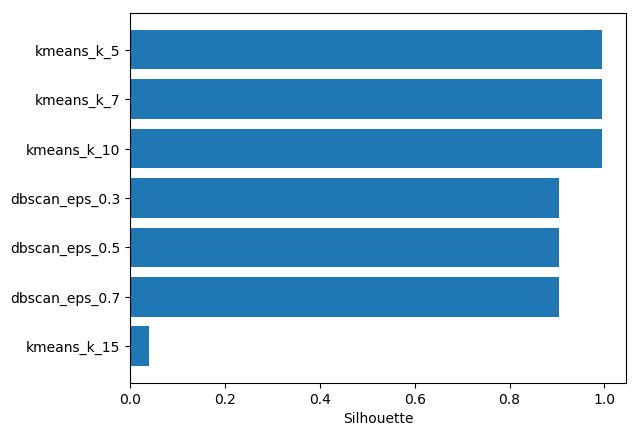

In [87]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

silhouette = ('kmeans_k_5', 'kmeans_k_7', 'kmeans_k_10', 'dbscan_eps_0.3', 'dbscan_eps_0.5', 'dbscan_eps_0.7', 'kmeans_k_15')
y_pos = np.arange(len(silhouette))
performance =(0.996, 0.995, 0.994, 0.904, 0.904, 0.904, 0.040)

ax.barh(y_pos, performance)
ax.set_yticks(y_pos)
ax.set_yticklabels(silhouette)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Silhouette')
#ax.set_title('')

plt.show()